In [1]:
from utils.data_handling import *
from utils.sensor_optimisation_gpy_sparse import *
from parameters import *
import GPy
import scipy.stats
from sklearn.covariance import GraphicalLasso


import matplotlib.pyplot as plt
np.random.seed(101)
%matplotlib inline

### Importing the Tracer Data to Select the Optimisation set S

In [2]:
parameters['i_end'] = 988
parameters['field_name'] = "Tracer"
parameters

{'i_start': 0,
 'i_end': 988,
 'crop': None,
 'field_name': 'Tracer',
 'cov_method': 'sample'}

In [3]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

  0%|          | 0/1 [00:00<?, ?it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


### Working subset of the data : set S

In [4]:
S = working_subset(data_df, loc_df, nbins = (25,25,25), threshold_sum = 10**-2 )

The remaining number of points is :  57725


### Import the Field of interest for computing the optimisation : TracerBackground / Pressure

In [5]:
parameters['i_end'] = 988
parameters['field_name'] = "Tracer"
parameters


{'i_start': 0,
 'i_end': 988,
 'crop': None,
 'field_name': 'Tracer',
 'cov_method': 'sample'}

In [6]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


In [39]:
X = loc_df.values #[I,:dim]
Z = data_df.values#[:,t].reshape(-1,1) # [I,t].reshape(-1,1)
Z.shape

(100040, 989)

### Detrending Data : 
Plotting the data along each direction in order to see if there is a obvious trend. It seams that it is not the case. 

In [49]:
# Tracer Starting point
X_0 = X[np.unravel_index(Z.argmax(), Z.shape)[0],:]
X_0

array([-23.50261288,  25.09719562,  11.76448376])

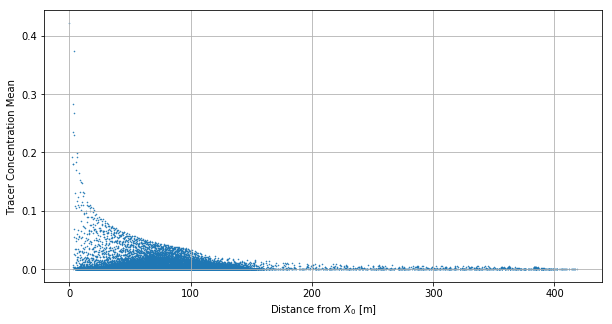

In [65]:
plt.figure(figsize=(10,5))
plt.scatter(np.linalg.norm(X[S,:] - X_0,axis=1),Z[S,:].mean(axis=1),s=0.3)
plt.xlabel(r'Distance from $X_0$ [m]')
plt.ylabel(r'Tracer Concentration Mean')
plt.grid()

Temporal Analysis : 

In [68]:
# Threshold bellow which everything is zero : 
thresh = 0.000000000001

Text(0.5, 1.0, 'Percentage of points over $\\tau$ = 1e-12')

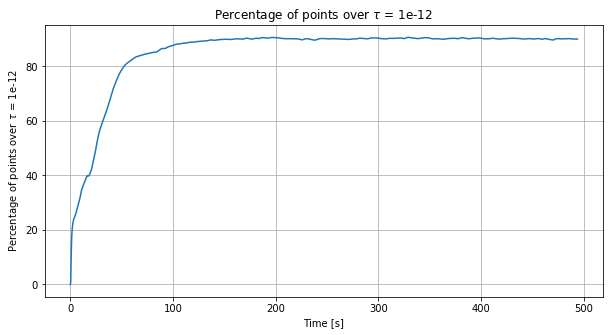

In [70]:
# plot of the non zero elements in function of the time 
plt.figure(figsize=(10,5))
plt.plot(time_df,100*np.sum(Z[S,:]>=thresh,axis=0)/len(S));
plt.xlabel('Time [s]')
plt.ylabel(r'Percentage of points over $\tau$ = ' + str(thresh))
plt.grid()
plt.title(r'Percentage of points over $\tau$ = ' + str(thresh))


In [ ]:
Z[Z<thresh] = 0
Z = Z[:,200:]
Z.shape

(100040, 789)

What should I do : 
- Cut the time at 200: ?
- replace the values bellow the threshold by 0 ? 


In [ ]:
Z[S,:] = (Z[S,:] - Z[S,:].mean(axis=1,keepdims=True))

In [ ]:
Z.shape

(100040, 789)

In [ ]:
%%time
Cov_SS = np.cov(Z[S[:],:])

CPU times: user 3min 34s, sys: 2min 14s, total: 5min 48s
Wall time: 1min 21s


In [ ]:
%%time
cov_SS_lasso = GraphicalLasso(verbose=True).fit(Z[S[:],:].T)


In [ ]:
cov_SS_lasso.covariance_.shape


In [70]:
Z[S[:],:]

(57725, 789)

In [16]:
Cov_SS.shape

(57725, 57725)

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
cax = ax.matshow(np.log(Cov_SS))
fig.colorbar(cax)

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
cax = ax.matshow(Cov_SS)
fig.colorbar(cax)

In [74]:
(6.50236874e-15) / np.sqrt(5.79668733e-14 * 1.58766630e-13)

0.06778007469854384